### Import dependencies

In [43]:
%matplotlib inline
import os as os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# visualizations and data cleaning
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
from IPython import display
import urllib.request
# peak finding
import scipy
from scipy import optimize
from scipy import signal
from ipywidgets import interact
from scipy.stats import linregress
# file reader
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [44]:
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd .../Magnetic_field_sweep  # Change directory to the address of the files

### Define functions

In [47]:
# get word to the right
def nextword(target, source):
    for i, w in enumerate(source):
        if w == target:
            return source[i+1]

# tick transformation between wavelength and energy
def tick_function(X):
    V = 1239.8*np.reciprocal(X)
    return ["%.0f" % z for z in V]

In [48]:
# lowpass filter

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 6     # order of filter
fs = 30.0     # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

b, a = butter_lowpass(cutoff, fs, order)

### Read .txt files

In [49]:
matrix_list = []

path_var = r".../Magnetic_field_sweep" # Set proper path variable

for path, currentDirectory, files in os.walk(path_var):
    for file in files:
        if file.startswith("") and file.endswith(".txt"):
            matrix_list.append(file)

In [50]:
matrix_list

['NKT_B_sweep.txt']

In [13]:
which_txt_file = 0

with open(matrix_list[which_txt_file],'r') as file_handle:
    raw_data = file_handle.readlines()

In [14]:
'''uncomment to look at raw data'''

#raw_data

'uncomment to look at raw data'

### Define classes

In [21]:
# define class

class B_measurements:
    frames = 0
    Lx = 0
    Ly = 0
    exposure_time = []
    QWP_exc = []
    QWP_det = []
    HWP_power = []
    B_field = []
    wavelength = []
    energy = []
    intensity = []

### Read metadata

In [22]:
raw_wavelength = raw_data[1]
wavelength = list(map(float, raw_wavelength.split("\t")))

exposure_time = nextword('Exp.time(s):', raw_data[2].split())
exposure_time = float(exposure_time)

frames = nextword('Frames:', raw_data[2].split())
frames = int(frames)

Lx = nextword('Lx:', raw_data[2].split())
Lx = int(Lx)

Ly = nextword('Ly:', raw_data[2].split())
Ly = int(Ly)

In [23]:
num_spectrum = ((len(raw_data)-2)-5)/3 + 1  #Total number of spectrum
print(num_spectrum)

303.0


In [25]:
var = B_measurements()

var.frames = frames
var.Lx = Lx

var.wavelength = wavelength
var.energy = (1239.8*np.reciprocal(var.wavelength))

for id in tqdm(range(int(num_spectrum))):

    var.exposure_time.append(exposure_time)
    params = raw_data[5+3*id]
    QWP_exc = list(map(float, params.split(" ")))[2]
    QWP_det = list(map(float, params.split(" ")))[3]
    HWP_power = list(map(float, params.split(" ")))[4]
    B_field = list(map(float, params.split(" ")))[5]

    var.QWP_exc.append(QWP_exc)
    var.QWP_det.append(QWP_det)
    var.HWP_power.append(HWP_power)
    var.B_field.append(B_field)

    intensity_data = raw_data[6+3*id]
    intensity_list = list(map(float, intensity_data.split("\t")))
    filtered_intensity_list = butter_lowpass_filter(intensity_list, cutoff, fs, order)      # Apply low pass filter
    var.intensity.append(filtered_intensity_list)

100%|██████████| 303/303 [00:00<00:00, 1616.68it/s]


In [26]:
### Save information in instances
data = var

In [27]:
## test code

d = {'QWP_exc': data.QWP_exc,
     'QWP_det': data.QWP_det,
     'HWP_power' : data.HWP_power,
     'B_field' : data.B_field,
     'intensity': data.intensity}

df = pd.DataFrame(data=d)

df.head(6)

,QWP_exc,QWP_det,HWP_power,B_field,intensity
0,73.5,51.0,88.8,0.0,"[0.18518028449866786, 2.0823415984586995, 11.5..."
1,73.5,51.0,133.8,0.0,"[0.09172424258037218, 1.0354291482393625, 5.73..."
2,73.5,51.0,178.8,0.0,"[0.1839985861269083, 2.082988274750625, 11.593..."
3,73.5,51.0,88.8,0.1,"[0.18031087224262413, 2.0360775746635236, 11.2..."
4,73.5,51.0,133.8,0.1,"[0.08976832803401151, 1.014691483339798, 5.630..."
5,73.5,51.0,178.8,0.1,"[0.1826946430960012, 2.069917006882325, 11.527..."


In [28]:
Bmin = min(df["B_field"])
Bmax = max(df["B_field"])
Anglemin = min(df["HWP_power"])
Anglemax = max(df["HWP_power"])

@interact(B_field=(Bmin, Bmax, 0.1), angle=(Anglemin, Anglemax, 45))
def plot(B_field = Bmin, angle = Anglemin):
    x = data.energy
    df_row = df.loc[(df['B_field'] == B_field) & (df['HWP_power'] == angle)]
    y = df_row["intensity"].tolist()[0] # unnesting list

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'k', lw=2)

    plt.xlim(1.58,1.68)
    plt.title("B = " + str(B_field) + ', Angle = ' + str(angle))
    plt.xlabel('Energy (eV)', fontsize=25)
    plt.ylabel('Intensity', fontsize=25)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='B_field', max=10.0), FloatSlider(value=88.8, descrip…

In [29]:
Bmin = min(df["B_field"])
Bmax = max(df["B_field"])

@interact(B_field=(Bmin, Bmax, 0.1))
def plot(B_field = Bmin):
    x = data.energy

    df_row = df.loc[(df['B_field'] == B_field) & (df['HWP_power'] == 88.8)]
    yLCP = df_row["intensity"].tolist()[0] # unnesting list

    df_row = df.loc[(df['B_field'] == B_field) & (df['HWP_power'] == 133.8)]
    yLin = df_row["intensity"].tolist()[0] # unnesting list

    df_row = df.loc[(df['B_field'] == B_field) & (df['HWP_power'] == 178.8)]
    yRCP = df_row["intensity"].tolist()[0] # unnesting list

    fig = plt.figure(figsize=(8,5))
    plt.plot(x, yLCP/max(yLCP)+1, 'b', lw=2, label = 'LHCP')
    plt.plot(x, yRCP/max(yRCP)+1, 'r', lw=2, label = 'RHCP')
    plt.plot(x, yLin/max(yLin), 'k', lw=2, label = 'Linear')

    plt.xlim(1.58,1.68)
    #plt.xlim(1.63,1.64)
    plt.title("B = " + str(B_field) + 'T')
    plt.xlabel('Energy (eV)', fontsize=25)
    plt.ylabel('Intensity', fontsize=25)
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='B_field', max=10.0), Output()), _dom_classes=('widge…

In [ ]:
## Create video

B_list = df["B_field"]
B_list = np.unique(B_list)

x = data.energy

# initializing a figure
fig = plt.figure(figsize=(8,6))
axis = fig.add_subplot(111)

# initializing a line variable
line, = axis.plot([], [], lw=1, marker="o")

def animate(f):
    axis.clear()
    id = df.loc[(df['B_field'] == B_list[f])].index.tolist()

    y1 = df['intensity'][id[0]]
    y2 = df['intensity'][id[1]]
    y3 = df['intensity'][id[2]]

    axis.plot(x, y1/max(y1)+1, color='b', lw=1.5, label='LHCP')
    axis.plot(x, y2/max(y2), color='k', lw=1.5, label='Linear')
    axis.plot(x, y3/max(y3)+1, color='r', lw=1.5, label='RHCP')

    plt.xlim(1.58,1.68)
    plt.title('B = ' + str(round(B_list[f],1)) + r'T')
    plt.xlabel('Energy (eV)', fontsize=25)
    plt.ylabel('Intensity', fontsize=25)
    plt.legend()
    return line,


anim1 = animation.FuncAnimation(fig, animate, frames=len(B_list),
                               interval=100, blit=True)


video = anim1.to_html5_video()  # converting to an html5 video
html = display.HTML(video)     # embedding for the video
display.display(html)          # draw the animation
plt.close()

#anim1.save("Magnetic field sweep.mp4")

## Find Zeeman splitting

In [30]:
dip_energy_list = []
x = data.energy

for id in tqdm(range(int(num_spectrum))):
  spectrum = df['intensity'][id].tolist()
  spectrum_range = [spectrum[i] for i in range(int(len(spectrum))) if 1.63 < x[i] < 1.634]
  dip_amp = min(spectrum_range)
  dip_energy = x[spectrum.index(dip_amp)]
  dip_energy_list.append(dip_energy)

df['dip_energy'] = dip_energy_list

100%|██████████| 303/303 [00:00<00:00, 3614.64it/s]


100%|██████████| 101/101 [00:00<00:00, 952.13it/s]


Text(0, 0.5, '$\\Delta$E (meV)')

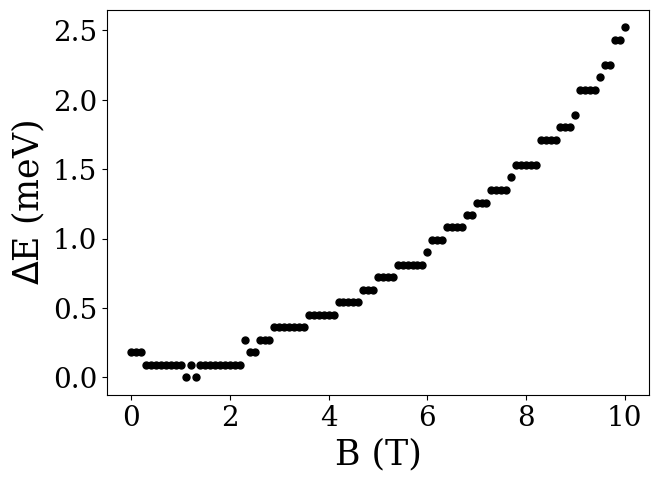

In [38]:
mu_B = 5.788382 * 10**-5

B_list = df["B_field"]
B_list = np.unique(B_list)

x = data.energy

# initializing a figure
fig, ax1 = plt.subplots(1,1,figsize=(7,5))

dE_list = []
g_factor_list = []

for B in tqdm(range(int(len(B_list)))):

  id = df.loc[(df['B_field'] == B_list[B])].index.tolist()

  dip1 = df['dip_energy'][id[0]]
  dip2 = df['dip_energy'][id[2]]

  dE = abs(dip2 - dip1)
  g_factor = dE/(mu_B * B_list[B])

  dE_list.append(dE)
  g_factor_list.append(g_factor)

dE_list_mev = [i*1000 for i in dE_list]
regression = linregress(B_list, dE_list)

ax1.plot(B_list, dE_list_mev, "ko", markersize=5, label='Data')

ax1.set_xlabel('B (T)', fontsize=25)
ax1.set_ylabel('$\Delta$E (meV)', fontsize=25)

In [39]:
# Get g-factor from slope

regression = linregress(B_list, dE_list)
slope = regression[0]
g_factor_fit = slope/mu_B
print(g_factor_fit)

4.0051147825003115
